# Exploration for commentary on the effect on proportions of cell type A and B in sampled multi-time clones

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import ipywidgets as widgets
import anndata
import os
import scipy
import copy
import matplotlib
import random
import math
import itertools

## Generate the simulated data

In [4]:
# Basic parameters of the system
t1 = 0
t2 = 1
n_simulations = 10
cell_types = ['A', 'B']
growth_rates = {'A': 1, 'B': 2}
n_cells_in_clones_at_t1 = {'A': 2, 'B': 4}

In [5]:
# Count the number of cells in all sets of interest for the computations below
n_cells_t1_in_types = {'A': 100, 'B': 100}
n_cells_t2_in_types = {}
n_cells_in_types = {}
n_clones_in_types = {}
n_cells_in_clones_at_t2 = {}
n_cells_in_clones = {}
for t in cell_types:
    n_cells_t2_in_types[t] = growth_rates[t]*n_cells_t1_in_types[t]
    n_cells_in_clones_at_t2[t] = growth_rates[t]*n_cells_in_clones_at_t1[t]
    
    assert  n_cells_t1_in_types[t] % n_cells_in_clones_at_t1[t] == 0
    n_clones_in_types[t] = n_cells_t1_in_types[t]//n_cells_in_clones_at_t1[t]
    
    assert n_cells_in_clones_at_t2[t]*n_clones_in_types[t] == n_cells_t2_in_types[t]

    n_cells_in_clones[t] = n_cells_in_clones_at_t1[t] + n_cells_in_clones_at_t2[t]
    n_cells_in_types[t] = n_cells_t1_in_types[t] + n_cells_t2_in_types[t]
    
n_clones =  np.sum(list(n_clones_in_types.values()))
n_cells_t1 = np.sum(list(n_cells_t1_in_types.values()))
n_cells_t2 = np.sum(list(n_cells_t2_in_types.values()))
n_cells_total = np.sum(list(n_cells_t1_in_types.values())) + np.sum(list(n_cells_t2_in_types.values()))

In [6]:
# Generate annotations (ids, order, type) for the cells
cell_ids = []
cell_order = []
cell_type = []
for c in cell_types:
    for i in range(n_cells_t1_in_types[c]):
        cell_ids.append(c + '_' + str(i))
        cell_order.append(t1)
        cell_type.append(c)
    for j in range(n_cells_t2_in_types[c]):
        cell_ids.append(c + '_' + str(j + n_cells_t1_in_types[c]))
        cell_order.append(t2)
        cell_type.append('AB')

In [7]:
# Generate clone labels
clone_labels = {}
clone_labels_for_t1_cells = {}
clone_labels_for_t2_cells = {}
for t in cell_types:
    clone_labels[t] = ['clone_' + t + '_' + str(i) for i in range(n_clones_in_types[t])]
    clone_labels_for_t1_cells[t] = []
    clone_labels_for_t2_cells[t] = []
    for i in range(n_clones_in_types[t]):
        for j in range(n_cells_in_clones_at_t1[t]):
            clone_labels_for_t1_cells[t].append(clone_labels[t][i])
        for k in range(n_cells_in_clones_at_t2[t]):
            clone_labels_for_t2_cells[t].append(clone_labels[t][i])
            
    assert len(clone_labels_for_t1_cells[t]) == n_cells_t1_in_types[t]
    assert len(clone_labels_for_t2_cells[t]) == n_cells_t2_in_types[t]

In [8]:
# Create an cell by clone matrix (clone membership matrix)  
X_clones = {} 
for c in cell_types:
    X_clones[c] = np.zeros((n_cells_total, n_clones_in_types[c]))

m = 0
for c in cell_types:
    for i in range(n_cells_t1_in_types[c]):
        clone_label = clone_labels_for_t1_cells[c][i]
        _, t, k = clone_label.split('_')
        assert t == c
        X_clones[c][m, int(k)] = 1
        m += 1
        
    for j in range(n_cells_t2_in_types[c]):
        clone_label = clone_labels_for_t2_cells[c][j]
        _, t, k = clone_label.split('_')
        assert t == c
        X_clones[c][m, int(k)] = 1
        m += 1
        
X_clone = np.concatenate([X_clones[c] for c in cell_types], axis=1)
assert np.all(np.sum(X_clone, axis=1) == 1), "At least one cell is assigned to more than one clone."
clone_totals = np.concatenate([n_cells_in_clones[t]*np.ones(n_clones_in_types[t]) for t in cell_types])
assert np.all(np.sum(X_clone, axis=0) == clone_totals), "Number of cells in each clone is incorrect."

In [9]:
# Store the simulated data in an anndata object
obs = pd.DataFrame({'time_info': cell_order, 'state_info': cell_type}, index=cell_ids)
adata = anndata.AnnData(X=X_clone, obs=obs)
adata.obsm['X_clone'] = X_clone
adata

AnnData object with n_obs × n_vars = 500 × 75
    obs: 'time_info', 'state_info'
    obsm: 'X_clone'

In [10]:
# Assign colors by cell type for plotting
celltype_color = {'A': 'tab:green',
                  'B': 'tab:red',
                  'AB': 'tab:blue'}


# Create the legend for the color dictionary
def lineage_elem(lin, color_dict):
    return Line2D([0], [0], marker='o', color='w', label=lin, markerfacecolor=color_dict[lin], markersize=10)

celltype_legend_handles = [lineage_elem(lin, celltype_color) for lin in celltype_color.keys()]
adata.obs['celltype_color'] = adata.obs['state_info'].apply(lambda x: celltype_color[x])

In [11]:
plt.rcParams.update({'font.size': 20})

## Sample, restrict to multi-time clones, and plot cell type proportions

In [12]:
# Define functions for the sampling process
def randomly_sample_timepoints(adata, times, rate):
    sampled_adata = []
    for t in times:
        adata_t = adata[adata.obs.time_info == t]
        n_cells_t = adata_t.n_obs
        idx_sampled_at_t = random.sample(range(n_cells_t), k=int(n_cells_t*rate))
        
        sampled_adata.append(adata_t[idx_sampled_at_t])
        
    return anndata.concat(sampled_adata)


def retain_multitime_only(adata, times, clone_idx):
    clone_sets = []
    for t in times:
        adata_t = adata[adata.obs.time_info == t]
        clones_at_t = list(np.where(np.sum(adata_t.obsm['X_clone'], axis=0) != 0)[0])
        clone_sets.append(set(clones_at_t))
    
    multitime_clones = clone_sets[0]
    for i in range(1, len(clone_sets)):
        multitime_clones = multitime_clones.intersection(clone_sets[i])
        
    multitime_mask = [i in multitime_clones for i in clone_idx]
    multitime = adata[np.sum(adata.obsm['X_clone'][:, multitime_mask], axis=1) != 0]
    return multitime
        

In [13]:
np.round(np.linspace(0.01, 1.0, 30)[::-1], decimals=2)

array([1.  , 0.97, 0.93, 0.9 , 0.86, 0.83, 0.8 , 0.76, 0.73, 0.69, 0.66,
       0.62, 0.59, 0.56, 0.52, 0.49, 0.45, 0.42, 0.39, 0.35, 0.32, 0.28,
       0.25, 0.21, 0.18, 0.15, 0.11, 0.08, 0.04, 0.01])

In [14]:
np.arange(20, step=2)

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18])

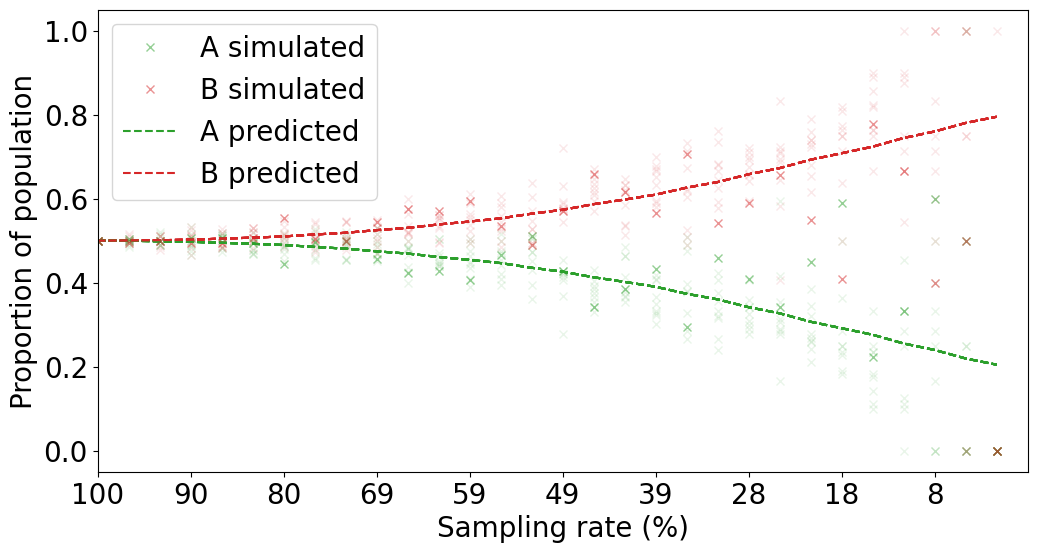

In [15]:
# Run the simulations and plot the results
sampling_rates = np.round(np.linspace(0.01, 1.0, 30)[::-1], decimals=2)
times = [t1, t2]
clone_idx = range(n_clones)

fig = plt.figure(figsize=(12,6))
fig.tight_layout()
for x in range(n_simulations):
    # Sample randomly at both timepoints
    randomly_sampled = {}
    sampled_adatas = {}
    for r in sampling_rates:
        temp_random = randomly_sample_timepoints(adata, times, r)
        k = str(np.round(r*100, decimals=0))
        randomly_sampled[k] = temp_random
        sampled_adatas[k] = retain_multitime_only(temp_random, times, clone_idx)
        
    # Create a cell census dataframe for the two timepoints
    census_dfs = {}
    for r in sampling_rates:
        k = str(np.round(r*100, decimals=0))
#         print("\n For sampling rate = {}".format(k))
        census_dfs[k] = pd.DataFrame({'time_info': [], 'A': [],'B': [], 'AB': []})

        for t in [t1, t2]:
            data = sampled_adatas[k].obs[sampled_adatas[k].obs.time_info == t]
            if data.shape[0] == 0:
                census_dfs[k].loc[len(census_dfs[k])] = {'time_info': t, 
                                          'A': 0, 
                                          'B': 0, 
                                          'AB': 0}
            else:
                census_dfs[k].loc[len(census_dfs[k])] = {'time_info': t, 
                                              'A': data[data['state_info'] == 'A'].shape[0]/data.shape[0], 
                                              'B': data[data['state_info'] == 'B'].shape[0]/data.shape[0], 
                                              'AB': data[data['state_info'] == 'AB'].shape[0]/data.shape[0]}

        census_dfs[k] = census_dfs[k].set_index('time_info')

    # Plot how the sampling process affects the cell census
#     plt.title("Cell type proportions at t1. \n Params: "
#                + "growth rates = {}, n cells in clones at t1 = {}, n cells in types at t1 = {}".format(
#                 growth_rates, n_cells_in_clones_at_t1, n_cells_t1_in_types))
    cell_type_labels = ['A', 'B']


    # Plotting the cell census changes
    sample_keys = list(census_dfs.keys())
    z_t1 = np.zeros((len(cell_types), len(sample_keys)))
    z_t2 = np.zeros((len(cell_types), len(sample_keys)))
    for i in range(len(sample_keys)):
        k = sample_keys[i]
        z_t1[:, i] = list(census_dfs[k].loc[t1][:-1])
        z_t2[:, i] = list(census_dfs[k].loc[t2][:-1])

   
    # Compute the probability that a cell in a clone (i.e. with a specific growth rate) 
    # will retain multi-time clone info
    p = np.zeros((len(cell_types), len(sample_keys)))
    for i in range(len(cell_types)):
        c = cell_types[i]
        for j in range(len(sample_keys)):
            r = sampling_rates[j]
            p[i, j] = r*(1-(1-r)**(growth_rates[c]*n_cells_in_clones_at_t1[c]))


    # Plot the probability that a cell with multitime info will be of a specific cell type
    p_type = np.zeros((len(cell_types), len(sample_keys)))
    for i in range(len(cell_types)):
        c = cell_types[i]
        p_type[i] = p[i]*n_cells_t1_in_types[c]/n_cells_t1


    # Plot the probability that a cell will be in MT and of a specific cell type
    p_type_given_MT = np.zeros((len(cell_types), len(sample_keys)))
    for i in range(len(cell_types)):
        for j in range(len(sample_keys)):
            c = cell_types[i]
            p_type_given_MT[i, j] = p_type[i, j]/np.sum(p_type[:,j])

        
    if x == n_simulations-1:
        for i in range(len(cell_type_labels)):
            t = cell_type_labels[i]
            plt.plot(z_t1[i], label=cell_type_labels[i] + ' simulated', 
                     color=celltype_color[t], alpha=0.5, marker='x', linestyle='')

        plt.ylabel("Proportion of population")
        plt.xlabel("Sampling rate (%)")
        locs, labels = plt.xticks()  # Get the current locations and labels.
        labels = [str(int(eval(i))) for i in sample_keys]
        plt.xticks(np.arange(30, step=3), labels[::3])  # Set text labels.
        plt.xlim((0, 30))
        
        for i in range(len(cell_types)):
            c = cell_types[i]
            plt.plot(p_type_given_MT[i], label=c + ' predicted', color=celltype_color[c], ls="--")
    else:
        for i in range(len(cell_type_labels)):
            t = cell_type_labels[i]
            plt.plot(z_t1[i], color=celltype_color[t], alpha=0.1, marker='x', linestyle='')
        
        for i in range(len(cell_types)):
            c = cell_types[i]
            plt.plot(p_type_given_MT[i], color=celltype_color[c], ls="--")     

plt.legend(loc='upper left')
plt.show()